In [1]:
import gc
import torch

# Assuming `obj` is the object consuming GPU memory
obj = None

# Collect garbage
gc.collect()

# Empty PyTorch cache
torch.cuda.empty_cache()

In [2]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the metadata with labels
metadata = pd.read_csv('/kaggle/input/my-dataset-with-labels/Forest Segmented/meta_data_with_labels_255_40.csv')

# Set the desired image size (e.g., 128x128) and normalize
IMG_SIZE = (256, 256)

def preprocess_image(image_path, img_size=IMG_SIZE):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Apply preprocessing to all images and stack into arrays
X = np.array([preprocess_image(f"/kaggle/input/my-dataset-with-labels/Forest Segmented/images/{name}") for name in metadata['image']])
y = np.array([1 if label == 'forested' else 0 for label in metadata['label']])  # Binary labels: 1 for forested, 0 for deforested


In [ ]:
# Split into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=40
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731041228.983272      96 service.cc:145] XLA service 0x7ca6a4004040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731041228.983334      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/128 ━━━━━━━━━━━━━━━━━━━━ 25:35 12s/step - accuracy: 0.4688 - loss: 0.6976

I0000 00:00:1731041235.216145      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 80s 537ms/step - accuracy: 0.6758 - loss: 0.6354 - val_accuracy: 0.7515 - val_loss: 0.5164
Epoch 2/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 479ms/step - accuracy: 0.7410 - loss: 0.5376 - val_accuracy: 0.7505 - val_loss: 0.5091
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 64s 475ms/step - accuracy: 0.7616 - loss: 0.5221 - val_accuracy: 0.7769 - val_loss: 0.4812
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 477ms/step - accuracy: 0.7857 - loss: 0.4918 - val_accuracy: 0.7554 - val_loss: 0.5161
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 482ms/step - accuracy: 0.7798 - loss: 0.4973 - val_accuracy: 0.7671 - val_loss: 0.4994
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 478ms/step - accuracy: 0.7751 - loss: 0.5028 - val_accuracy: 0.7926 - val_loss: 0.4456
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 478ms/step - accuracy: 0.7895 - loss: 0.4809 - val_accuracy: 0.7857 - val_loss: 0.4642
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 65s 479ms/step - accuracy: 0.7832 - loss: 0.4798 - val

In [6]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8225 - loss: 0.4156
Test Accuracy: 82.09%


In [7]:
model.save('/kaggle/working/sequential.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


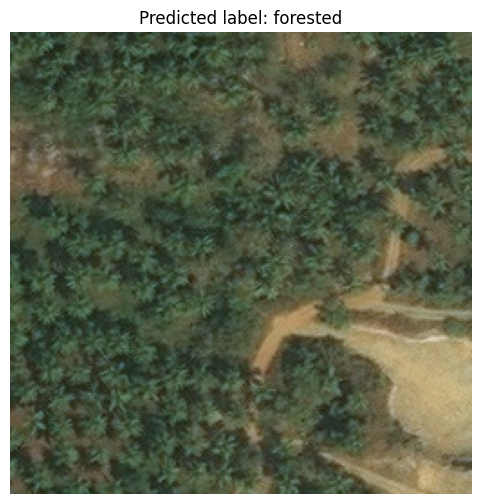

In [15]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/kaggle/working/sequential.h5')

# Function to preprocess a single image for prediction
def preprocess_image_for_prediction(image_path, img_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension (1, 256, 256, 3)
    return image

# Path to the input image for prediction
input_image_path = "/kaggle/input/my-dataset-with-labels/Forest Segmented/images/111335_sat_44.jpg"  # Replace with your image path

# Preprocess the image
input_image = preprocess_image_for_prediction(input_image_path)

# Make prediction
prediction = model.predict(input_image)
predicted_label = "forested" if prediction[0][0] >= 0.5 else "deforested"

# Load the image for display
display_image = cv2.imread(input_image_path)
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Display the image with the prediction
plt.figure(figsize=(6, 6))
plt.imshow(display_image)
plt.title(f"Predicted label: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


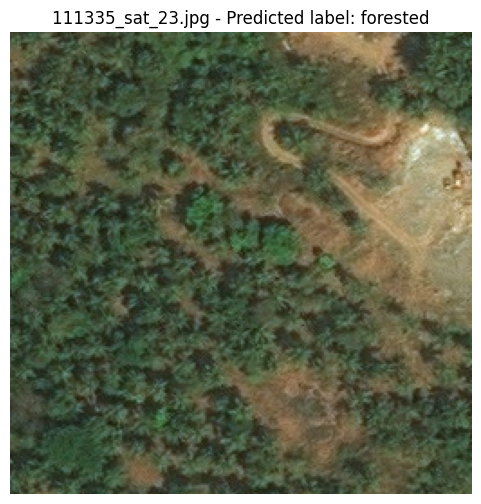

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


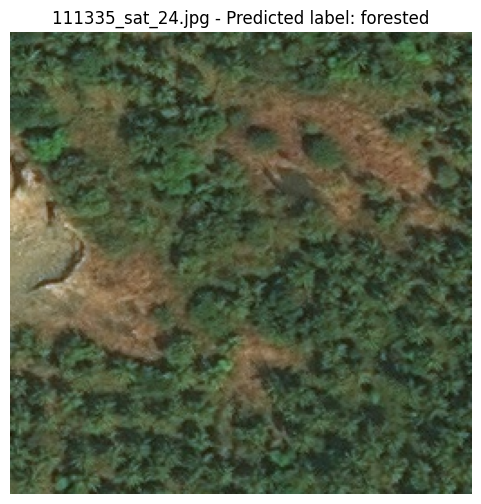

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


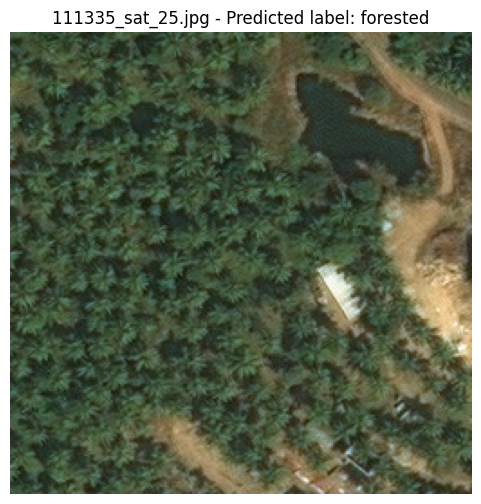

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


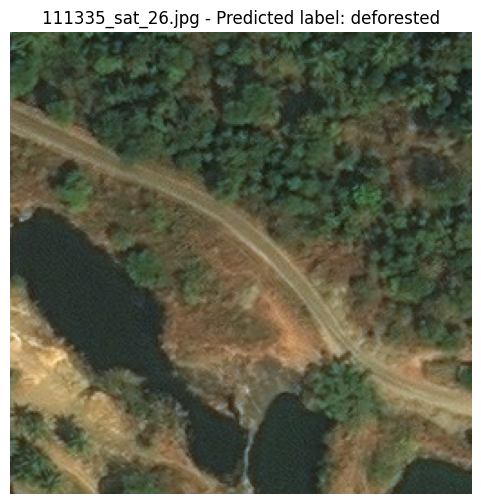

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


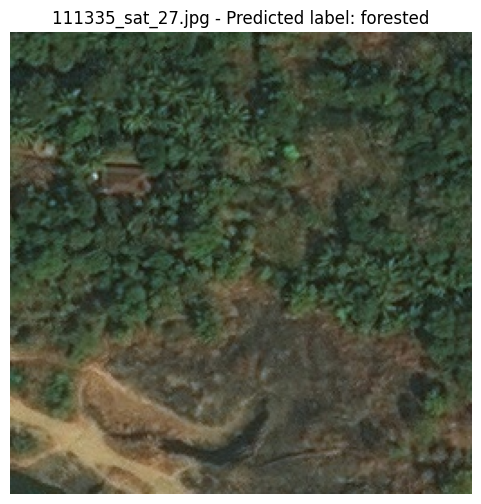

In [19]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/kaggle/working/sequential.h5')

# Function to preprocess a single image for prediction
def preprocess_image_for_prediction(image_path, img_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension (1, 256, 256, 3)
    return image

# List of image filenames to predict
image_filenames = [f"111335_sat_2{i}.jpg" for i in range(3, 8)]
image_folder = "/kaggle/input/my-dataset-with-labels/Forest Segmented/images/"

# Loop through each image, predict, and display with label
for image_name in image_filenames:
    image_path = f"{image_folder}{image_name}"
    
    # Preprocess the image
    input_image = preprocess_image_for_prediction(image_path)
    
    # Make prediction
    prediction = model.predict(input_image)
    predicted_label = "forested" if prediction[0][0] >= 0.5 else "deforested"
    
    # Load the image for display
    display_image = cv2.imread(image_path)
    display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    
    # Display the image with the prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(display_image)
    plt.title(f"{image_name} - Predicted label: {predicted_label}")
    plt.axis('off')
    plt.show()
